In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/data")
df_rf_15 = pd.read_csv('df_rf_15.csv')
df_rf_20 = pd.read_csv('df_rf_20.csv')
df_rf_25 = pd.read_csv('df_rf_25.csv')
df_rf_30 = pd.read_csv('df_rf_30.csv')
df_rf_35 = pd.read_csv('df_rf_35.csv')
df_rf_40 = pd.read_csv('df_rf_40.csv')
df_rf_45 = pd.read_csv('df_rf_45.csv')
heroes= pd.read_csv('heroes.csv')
heroes = heroes.rename(columns = {'id':'hero_id'})
df2_allhero = pd.read_csv('df2_allhero.csv') # We use this to instantiate the embedding layer since thats how the embedding layers were created and i want to avoid any shenanigans like the hero_ids and their indexes getting jumbled due to ordering when they get mapped by hero_id_to_idx

os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/")
%run LSTM_Model_Classes.ipynb

os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models")
model_dict_10_5_rmse_84 = torch.load('10step_5horizon_RMSE_84.pth') #done
model_dict_5_5_rmse_84 = torch.load('5step_5horizon_RMSE_84.pth') #error?
model_dict_10_5_rmse_8 = torch.load('10step_5horizon_RMSE_8.pth') #done
model_dict_5_5_rmse_8 = torch.load('5step_5horizon_RMSE_8.pth') #done


In [4]:
RMSE_embed_weights = model_dict_10_5_rmse_84['process_embedding.process_embeddings.weight']

In [6]:
#10step_5Horizon_rmse_84
lookback = 10
horizon = 5
embed_dim = 84
model_dict = model_dict_10_5_rmse_84
file_name = '10_5_84'


RMSE_embedding = ProcessEmbedding(df2_allhero, embedding_dim=embed_dim, lookback=lookback)
RMSE_embedding.process_embeddings.weight = nn.Parameter(RMSE_embed_weights) # Load the old weights into the new embedding layer


In [11]:
columns_to_drop = df_rf_15.filter(regex=r'\d_gold$').columns #dropping columns that contain the time-series tensors
df_rf_15 = df_rf_15.drop(columns=columns_to_drop)

In [12]:
df_rf_15.columns

Index(['match_id', 'rad_pos1', 'rad_pos2', 'rad_pos3', 'rad_pos4', 'rad_pos5',
       'rad_pos1_last_gold', 'rad_pos2_last_gold', 'rad_pos3_last_gold',
       'rad_pos4_last_gold', 'rad_pos5_last_gold', 'dire_pos1', 'dire_pos2',
       'dire_pos3', 'dire_pos4', 'dire_pos5', 'dire_pos1_last_gold',
       'dire_pos2_last_gold', 'dire_pos3_last_gold', 'dire_pos4_last_gold',
       'dire_pos5_last_gold', 'pos1_diff', 'pos2_diff', 'pos3_diff',
       'pos4_diff', 'pos5_diff', 'team_diff', 'minute', 'winner'],
      dtype='object')

In [28]:
def iterate_ids(id_array):
  # Takes in a numpy array, and feeds the values one by one into the embedding layer
  # Returns the embedding representation that can replace the column
  hero_embeddings_list = []
  for hero_id in id_array:
      embedding = RMSE_embedding(hero_id).detach().numpy()
      hero_embeddings_list.append(embedding)

  #print(hero_embeddings_list)

  hero_embeddings_tensor = torch.tensor(hero_embeddings_list)
  return hero_embeddings_tensor

In [ ]:
# We need to loop over the hero_id's since the ProcessEmbedding layer is expecting one hero_id at a time

# Below is commented out to show that depending on which dataframe we feed the hero_ids from we get different tensor embeddings.
# We will stick with the original embedding although it should technically work the same

# hero_embeddings = []
# for hero_id in heroes['hero_id']:
#     embedding = RMSE_embedding(hero_id)
#     hero_embeddings.append(embedding)

# hero_embeddings = torch.stack(hero_embeddings)

# hero_embeddings_df2 = []
# for hero_id in df2_allhero['hero_id']:
#     embedding = RMSE_embedding(hero_id)
#     hero_embeddings_df2.append(embedding)

# hero_embeddings_df2 = torch.stack(hero_embeddings_df2)

# hero_embeddings_df2 == hero_embeddings

In [38]:
def get_hero_embedding_and_concat_features(df):
  # Extract the hero_ids for each position from your dataframe

  hero_columns = ['rad_pos1', 'rad_pos2', 'rad_pos3', 'rad_pos4', 'rad_pos5',
                'dire_pos1', 'dire_pos2', 'dire_pos3', 'dire_pos4', 'dire_pos5']

  hero_embeddings = {col: iterate_ids(df[col].values) for col in hero_columns}

  # Create new columns for each hero position's embedded representations
  embedded_columns = {}
  for col in hero_columns:
      embeddings = hero_embeddings[col].detach().numpy()
      embeddings = embeddings.reshape(embeddings.shape[0],-1)
      print(embeddings.shape)
      num_rows, num_features = embeddings.shape
      for i in range(num_features):
        embedded_columns[f"{col}_embed_{i+1}"] = embeddings[:, i].flatten()


  # Get the embedding vectors for each position using the trained embedding layer
  # We need to call another .detach().numpy() here since we were still getting the autograd error from PyTorch
  # We also needed to reshape the embeddings to remove an extra dimension, without the reshape(-1,84), their shapes were (995, 1, 84) now they're (995,84)

  combined_features_df = pd.DataFrame({
      **embedded_columns, # '**' unpacks a dictionary and passes the dict as key-value pais
      # this effectively replaces typing the below:
      #'rad_pos1_embed_1 : [..],
      #'rad_pos1_embed_2 : [..]

      'rad_pos1_last_gold': df['rad_pos1_last_gold'],
      'rad_pos2_last_gold': df['rad_pos2_last_gold'],
      'rad_pos3_last_gold': df['rad_pos3_last_gold'],
      'rad_pos4_last_gold': df['rad_pos4_last_gold'],
      'rad_pos5_last_gold': df['rad_pos5_last_gold'],
      'dire_pos1_last_gold': df['dire_pos1_last_gold'],
      'dire_pos2_last_gold': df['dire_pos2_last_gold'],
      'dire_pos3_last_gold': df['dire_pos3_last_gold'],
      'dire_pos4_last_gold': df['dire_pos4_last_gold'],
      'dire_pos5_last_gold': df['dire_pos5_last_gold'],
      'pos1_diff': df['pos1_diff'],
      'pos2_diff': df['pos2_diff'],
      'pos3_diff': df['pos3_diff'],
      'pos4_diff': df['pos4_diff'],
      'pos5_diff': df['pos5_diff'],
      'team_diff': df['team_diff'],
      'winner': df['winner']
  })


  return combined_features_df

df_rf_15_embed = get_hero_embedding_and_concat_features(df_rf_15)


(995, 84)
(995, 84)
(995, 84)
(995, 84)
(995, 84)
(995, 84)
(995, 84)
(995, 84)
(995, 84)
(995, 84)


In [39]:
df_rf_15_embed.shape

(995, 857)

Split RF Structures for Model Training

In [41]:
# from sklearn.datasets import load_iris
def split_data(df, test_size):
  X = df.drop('winner', axis=1)
  y = df['winner']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

  return X_train, X_test, y_train, y_test



In [42]:
rf_15_X_train, rf_15_X_test, rf_15_y_train, rf_15_y_test = split_data(df_rf_15_embed, test_size = .30)

In [ ]:
rf_15_y_train

In [56]:
# Create an instance of the random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42, ccp_alpha= .01)

# Train the random forest classifier with the combined features and labels
rf_classifier.fit(rf_15_X_train, rf_15_y_train)

RandomForestClassifier(ccp_alpha=0.01, n_estimators=1000, random_state=42)

In [57]:
# Make predictions on the test set
y_pred = rf_classifier.predict(rf_15_X_test)

# Evaluate the model
accuracy = accuracy_score(rf_15_y_test, y_pred)
precision = precision_score(rf_15_y_test, y_pred, average='weighted')
recall = recall_score(rf_15_y_test, y_pred, average='weighted')
f1 = f1_score(rf_15_y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.7191
Precision: 0.7209
Recall: 0.7191
F1-score: 0.7179


Accuracy: 0.7391
Precision: 0.7402
Recall: 0.7391
F1-score: 0.7385


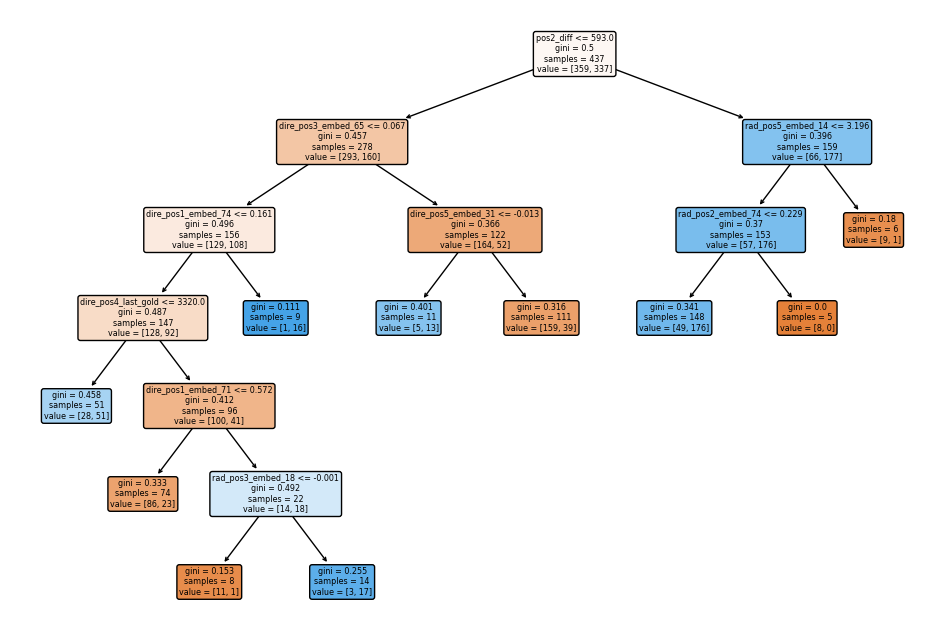

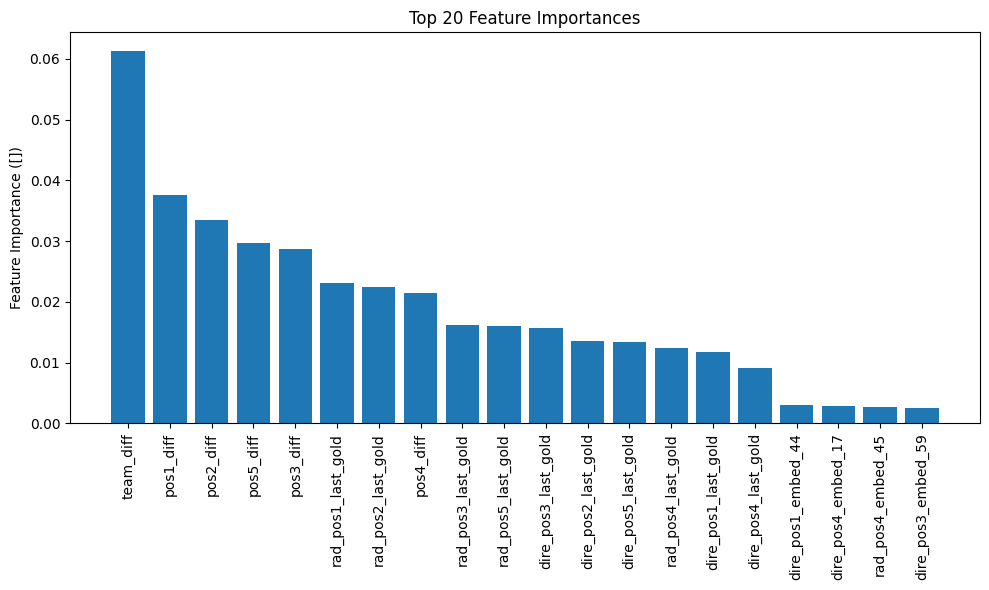

In [58]:
# Plot a decision tree from the random forest
plt.figure(figsize=(12, 8))
tree = rf_classifier.estimators_[2]  # Get the first tree in the forest
plot_tree(tree, filled=True, rounded=True, feature_names=rf_15_X_train.columns)
plt.show()

# Plot feature importances
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = rf_15_X_train.columns

# Select the top 15 features
top_n = 20
top_indices = indices[:top_n]
top_feature_names = [feature_names[i] for i in top_indices]
top_importances = importances[top_indices]

plt.figure(figsize=(10, 6))
plt.title(f"Top {top_n} Feature Importances")
plt.bar(range(top_n), top_importances)
plt.xticks(range(top_n), top_feature_names, rotation=90)
plt.ylabel('Feature Importance ([])')
plt.tight_layout()
plt.show()

XGBoost

In [ ]:
# Create an instance of the random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42, ccp_alpha= .01)

# Train the random forest classifier with the combined features and labels
rf_classifier.fit(rf_15_X_train, rf_15_y_train)



In [62]:
rf_15_y_train_binary = rf_15_y_train.replace({'dire': 0, 'radiant': 1})
rf_15_y_test_binary = rf_15_y_test.replace({'dire': 0, 'radiant': 1})

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}
Accuracy: 0.7224
Precision: 0.7224
Recall: 0.7224
F1-score: 0.7222


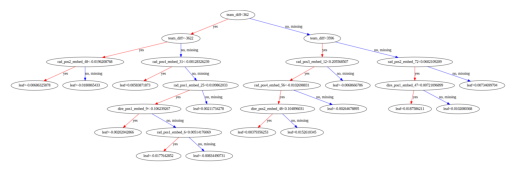

In [67]:
from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [200, 300],
    'max_depth':  [10],
    'learning_rate': [0.01], #,0.1],
    'subsample': [0.8], #,1.0],
    'colsample_bytree': [0.8], #, 1.0],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 5, 10]
}

# Create an instance of XGBClassifier
xgbclass = XGBClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgbclass, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(rf_15_X_train, rf_15_y_train_binary)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(rf_15_X_test)

# Evaluate the model
accuracy = accuracy_score(rf_15_y_test_binary, y_pred)
precision = precision_score(rf_15_y_test_binary, y_pred, average='weighted')
recall = recall_score(rf_15_y_test_binary, y_pred, average='weighted')
f1 = f1_score(rf_15_y_test_binary, y_pred, average='weighted')

print(f"Best parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Plot a single tree from the best model
plot_tree(best_model)
plt.show()

Automated

In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models")
model_dict_10_5_rmse_84 = torch.load('10step_5horizon_RMSE_84.pth') #done
model_dict_5_5_rmse_84 = torch.load('5step_5horizon_RMSE_84.pth') #error?
model_dict_10_5_rmse_8 = torch.load('10step_5horizon_RMSE_8.pth') #done
model_dict_5_5_rmse_8 = torch.load('5step_5horizon_RMSE_8.pth') #done


In [ ]:
#10step_5Horizon_rmse_84
RMSE_embed_weights = model_dict_10_5_rmse_84['process_embedding.process_embeddings.weight']
lookback = 10
horizon = 5
embed_dim = 84
model_dict = model_dict_10_5_rmse_84
file_name = '10_5_84'


RMSE_embedding = ProcessEmbedding(df2_allhero, embedding_dim=embed_dim, lookback=lookback)
RMSE_embedding.process_embeddings.weight = nn.Parameter(RMSE_embed_weights) # Load the old weights into the new embedding layer
